# Summary of Inter GPU Point-to-Point Communication between Two Nodes

In [1]:
%matplotlib inline
import glob
import os
import re

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

SAVE_FIGURE = False
FIGURE_FONT_SIZE = 12

plt.rcParams["figure.dpi"] = 120
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.size'] = FIGURE_FONT_SIZE
pd.set_option('precision', 3)
pd.set_option('display.max_columns', 20)

project_dir = os.getcwd()
dir_anode_results = f'{project_dir}/inter_anode'
dir_vnode_results = f'{project_dir}/inter_vnode'

In [2]:
# function definitions

def read_data_from_file(filepath, name=None):
    pattern = '# Size'
    in_data = False
    lines = []
    with open(filepath) as inf:
        for line in inf:
            line = line.strip()
            if not in_data:
                if line.startswith(pattern):
                    in_data = True
                    continue
            else:
                lines.append(line)

    index = [int(line.split()[0]) for line in lines]
    data = [float(line.split()[1]) for line in lines]
    return pd.Series(data=data, index=index, name=name)

def load_data(metrics):
    node_types = {
        'anode': dir_anode_results,
        'vnode': dir_vnode_results
    }
    mem_types = {
        'host': 'prc',
        'gpu': 'gpu'
    }
    procs = [1, 4, 8]

    series = []
    for mem, suffix in mem_types.items():
        for node, dirpath in node_types.items():
            for proc in procs:
                column_key = f'{mem}:{node}:{proc}'
                file_pattern = f'{dirpath}/job{proc:02d}.sh.*.{suffix}.{metrics}'
                files = glob.glob(file_pattern)
                if not files:
                    continue
                data = read_data_from_file(files[0], column_key)
                series.append(data)
    return pd.concat(series, axis=1)

def plot(data, column_labels, markers, title, ylabel):
    def _xticks_labels():
        idxs = [2, 6, 10, 14, 18, 22]
        xticks = [2**i for i in idxs]
        labels = []
        for val in xticks:
            if val < 1024:
                labels.append(str(val))
            elif val < 1024 * 1024:
                labels.append(str(val // 1024) + 'K')
            else:
                labels.append(str(val // 1024 // 1024) + 'M')
        return xticks, labels

    data0 = data[column_labels.keys()]
    data0 = data0.rename(columns=column_labels)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.set_xlabel('Message Size (Bytes)')
    ax.set_xscale('log', base=2)
    xticks, xticklabels = _xticks_labels()
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

    ax.set_ylabel(ylabel)
    ax.set_yscale('log')

    data0.plot(ax=ax, style=markers)
    if SAVE_FIGURE:
        fig.savefig(f'{title}.pdf')
    ax.set_title(title)
    
def plot_bandwidth(data, column_labels, markers, title):
    plot(data, column_labels, markers, title, 'Bandwidth (MB/s)')

def plot_latency(data, column_labels, markers, title):
    plot(data, column_labels, markers, title, 'Time (Micro-second)')

## Bandwidth

In [3]:
bw_data = load_data('bandwidth')
bw_data

,host:anode:1,host:anode:4,host:anode:8,host:vnode:1,host:vnode:4,gpu:anode:1,gpu:anode:4,gpu:anode:8,gpu:vnode:1,gpu:vnode:4
1,5.45,19.52,45.65,5.62,16.42,3.06,10.61,22.18,2.59,6.66
2,10.94,45.05,91.80,11.21,41.72,4.63,23.28,46.23,2.89,19.57
4,21.90,89.82,182.40,22.00,83.12,12.49,46.92,93.45,10.26,39.44
8,43.70,179.88,365.75,44.46,168.48,24.91,93.69,185.36,20.83,78.22
16,87.62,359.39,731.99,80.75,337.23,49.36,187.46,369.13,43.17,156.32
32,174.21,717.49,1461.75,175.24,670.47,100.06,373.99,745.72,85.43,295.94
64,342.11,1357.45,2748.81,331.28,1274.33,161.87,631.50,1326.49,161.67,583.47
128,634.10,2607.56,5264.52,638.68,2436.12,376.54,1406.01,2758.80,314.97,1146.26
256,1010.97,4133.62,8433.32,1105.62,4126.99,691.71,2712.74,5397.16,617.71,2134.46
512,1932.62,7885.49,15993.87,1846.41,7359.76,1315.21,5224.44,10334.89,1003.83,2517.79


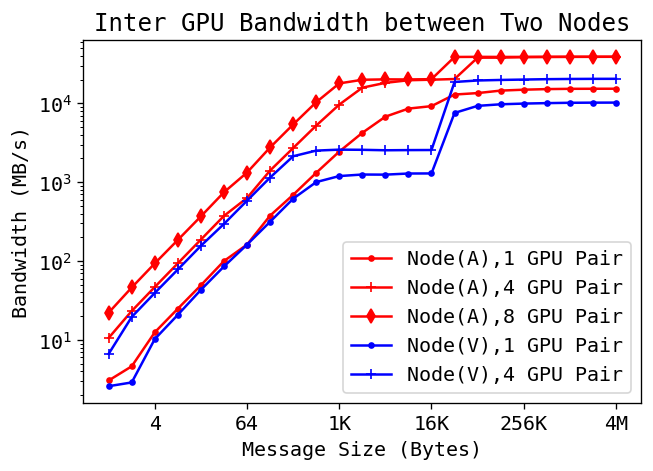

In [4]:
title = 'Inter GPU Bandwidth between Two Nodes'
column_labels = {
    'gpu:anode:1': 'Node(A),1 GPU Pair',
    'gpu:anode:4': 'Node(A),4 GPU Pair',
    'gpu:anode:8': 'Node(A),8 GPU Pair',
    'gpu:vnode:1': 'Node(V),1 GPU Pair',
    'gpu:vnode:4': 'Node(V),4 GPU Pair',
}
markers = ['r.-', 'r+-', 'rd-', 'b.-', 'b+-']
plot_bandwidth(bw_data, column_labels, markers, title)

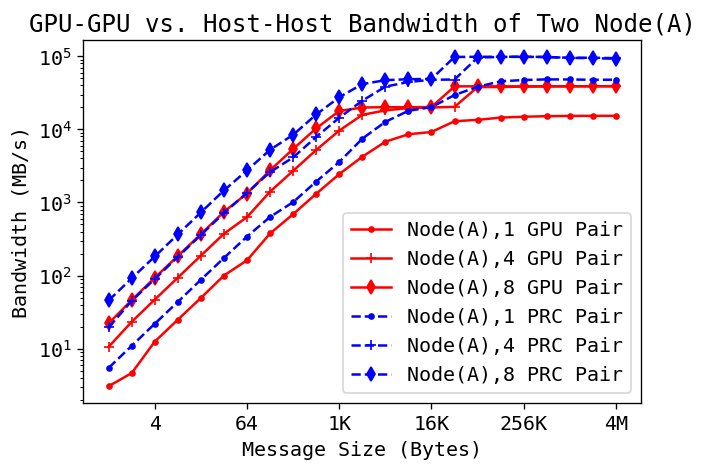

In [5]:
title = 'GPU-GPU vs. Host-Host Bandwidth of Two Node(A)'
column_labels = {
    'gpu:anode:1': 'Node(A),1 GPU Pair',
    'gpu:anode:4': 'Node(A),4 GPU Pair',
    'gpu:anode:8': 'Node(A),8 GPU Pair',
    'host:anode:1': 'Node(A),1 PRC Pair',
    'host:anode:4': 'Node(A),4 PRC Pair',
    'host:anode:8': 'Node(A),8 PRC Pair',
}
markers = ['r.-', 'r+-', 'rd-', 'b.--', 'b+--', 'bd--']
plot_bandwidth(bw_data, column_labels, markers, title)

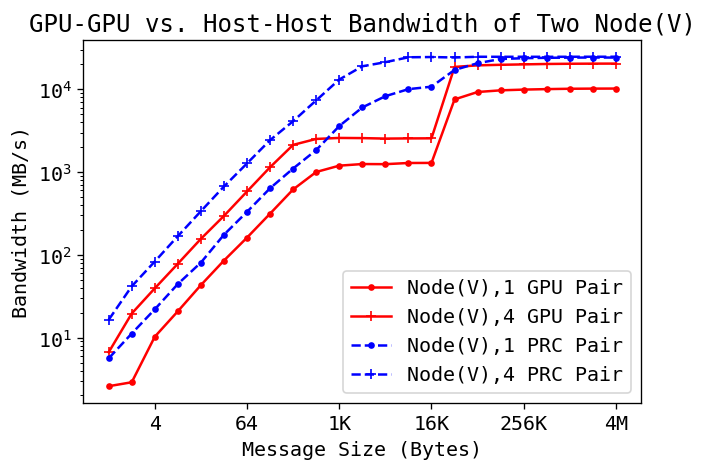

In [6]:
title = 'GPU-GPU vs. Host-Host Bandwidth of Two Node(V)'
column_labels = {
    'gpu:vnode:1': 'Node(V),1 GPU Pair',
    'gpu:vnode:4': 'Node(V),4 GPU Pair',
    'host:vnode:1': 'Node(V),1 PRC Pair',
    'host:vnode:4': 'Node(V),4 PRC Pair',
}
markers = ['r.-', 'r+-', 'b.--', 'b+--']
plot_bandwidth(bw_data, column_labels, markers, title)

# Latency

In [7]:
lat_data = load_data('latency')
lat_data

,host:anode:1,host:anode:4,host:anode:8,host:vnode:1,host:vnode:4,gpu:anode:1,gpu:anode:4,gpu:anode:8,gpu:vnode:1,gpu:vnode:4
0,1.47,1.45,1.36,0.87,1.05,2.12,2.09,2.15,1.29,1.44
1,1.47,1.42,1.35,0.86,0.89,3.29,3.39,3.85,2.54,2.58
2,1.47,1.42,1.34,0.87,0.89,3.38,3.21,3.28,2.38,2.47
4,1.47,1.42,1.35,0.87,0.89,3.29,3.21,3.28,2.40,2.46
8,1.47,1.42,1.35,0.87,0.89,3.29,3.21,3.25,2.38,2.46
16,1.47,1.42,1.35,0.87,0.90,3.30,3.24,3.27,2.38,2.46
32,1.50,1.45,1.37,0.91,0.94,3.33,3.42,3.96,2.43,2.58
64,1.57,1.51,1.44,1.04,1.06,3.47,3.52,4.03,2.52,2.68
128,1.61,1.55,1.48,1.06,1.09,3.49,3.50,4.04,2.55,2.70
256,1.88,1.83,1.76,1.56,1.58,3.47,3.56,4.08,2.62,2.81


In [8]:
lat_data = lat_data.drop(0, axis=0)

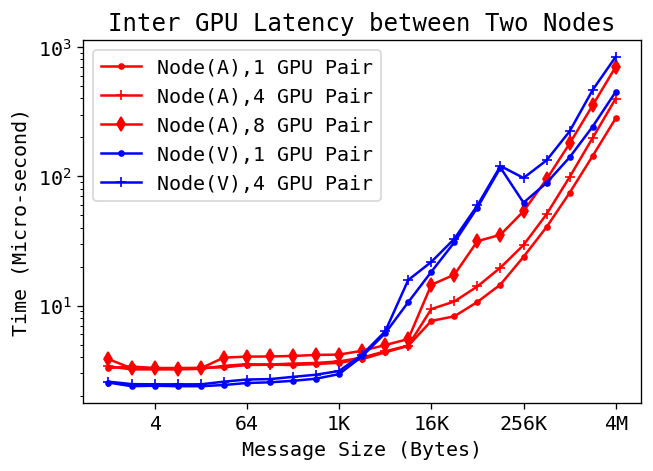

In [9]:
title = 'Inter GPU Latency between Two Nodes'
column_labels = {
    'gpu:anode:1': 'Node(A),1 GPU Pair',
    'gpu:anode:4': 'Node(A),4 GPU Pair',
    'gpu:anode:8': 'Node(A),8 GPU Pair',
    'gpu:vnode:1': 'Node(V),1 GPU Pair',
    'gpu:vnode:4': 'Node(V),4 GPU Pair',
}
markers = ['r.-', 'r+-', 'rd-', 'b.-', 'b+-']
plot_latency(lat_data, column_labels, markers, title)

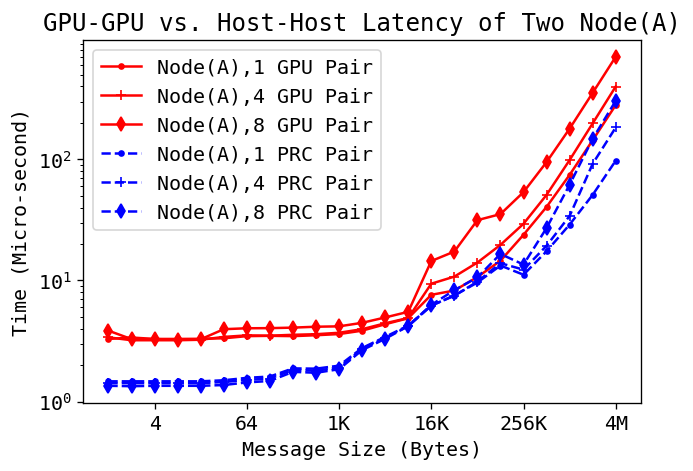

In [10]:
title = 'GPU-GPU vs. Host-Host Latency of Two Node(A)'
column_labels = {
    'gpu:anode:1': 'Node(A),1 GPU Pair',
    'gpu:anode:4': 'Node(A),4 GPU Pair',
    'gpu:anode:8': 'Node(A),8 GPU Pair',
    'host:anode:1': 'Node(A),1 PRC Pair',
    'host:anode:4': 'Node(A),4 PRC Pair',
    'host:anode:8': 'Node(A),8 PRC Pair',
}
markers = ['r.-', 'r+-', 'rd-', 'b.--', 'b+--', 'bd--']
plot_latency(lat_data, column_labels, markers, title)

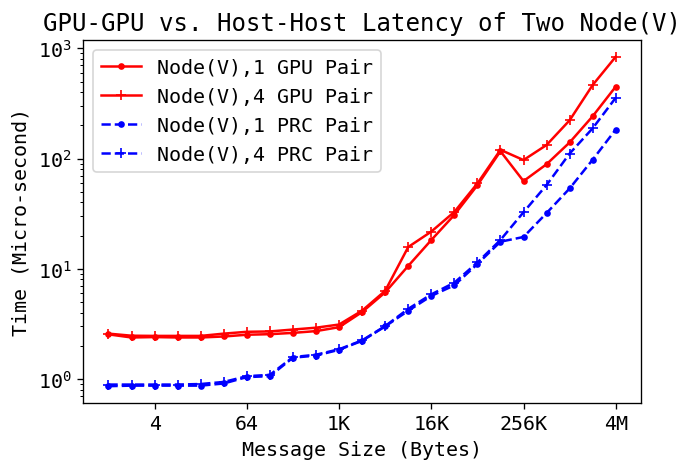

In [11]:
title = 'GPU-GPU vs. Host-Host Latency of Two Node(V)'
column_labels = {
    'gpu:vnode:1': 'Node(V),1 GPU Pair',
    'gpu:vnode:4': 'Node(V),4 GPU Pair',
    'host:vnode:1': 'Node(V),1 PRC Pair',
    'host:vnode:4': 'Node(V),4 PRC Pair',
}
markers = ['r.-', 'r+-', 'b.--', 'b+--']
plot_latency(lat_data, column_labels, markers, title)